In [ ]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
from scipy.stats import binned_statistic
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes
from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
output_notebook()
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV

sys.path.append("../")
from importlib import reload
import stack_spectra
reload(stack_spectra)

In [ ]:
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [ ]:
spec = desispec.io.read_spectra(my_path /  "spectra_bright.fits")
zcat = Table.read(my_path / "zcat_bright.fits")
flux_cam = spec.flux
wave_cam = spec.wave
ivar_cam = spec.ivar

In [ ]:
red = [0,2,4,5,6,8,9,11, 12, 13, 14, 15]
blue = [1,3,7,10]
# test = [7,10]
test =[0,10]

In [ ]:
flux, wave, ivar = stack_spectra._coadd_cameras(flux_cam, wave_cam, ivar_cam)

In [ ]:
flux = flux[test]
ivar = ivar[test]
z = zcat[test]["Z"]

In [ ]:
plt.figure(figsize=(10,4))
for i in range(2):
    plt.plot(wave, flux[i])
# plt.xlim(5000, 7000)
# plt.axvline(5896)

In [ ]:
new_f,new_i,new_wl = stack_spectra._common_grid(flux, wave, ivar, z, z_out=0.0, wave_grid=None)

In [ ]:
plt.figure(figsize=(10,4))
for i in range(2):
    plt.plot(new_wl, new_f[i])
plt.xlim(5250, 6750)

In [ ]:
new_f, new_i = stack_spectra._normalize(new_f,new_i)

In [ ]:
plt.figure(figsize=(10,4))
for i in range(2):
    plt.plot(new_wl, new_f[i])

In [ ]:
wavg_f = stack_spectra._wavg(new_f,new_i)

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(new_wl,wavg_f)
plt.ylim(-0.25,1.25)

In [ ]:
# index =1
p = figure(title="Spectra", x_axis_label='Wavelength', y_axis_label='Flux', plot_width=1000, plot_height=300, 
           y_range=(-1, 3)
          )
p.line(new_wl, wavg_f, legend_label="Temp.", line_width=2)
# p.line(new_wl, convolve(wavg_f,Gaussian1DKernel(3)), legend_label="Temp.", line_width=2, color="orange")

show(p)

In [ ]:
# save(p, "plot.html")

### Model Ivar using sky

In [ ]:
sky = desispec.io.read_spectra(my_path /  "sky_bright.fits")

In [ ]:
sky_f = sky.flux
sky_i = sky.ivar
sky_w = sky.wave

In [ ]:
sky_f, wave, sky_i = stack_spectra._coadd_cameras(sky_f, sky_w, sky_i)

In [ ]:
sky_f = sky_f[test]
sky_i = sky_i[test]

In [ ]:
def process_sky_ivar(sky_ivar, sky_wave):
    n_obj = len(sky_ivar)
#     sky_wave = np.tile(sky_wave, (n_obj,1))
    sky_var = 1/sky_ivar
    for i in range(n_obj):
        mask = np.isfinite(sky_var[i])
        sky_var_interp = interp1d(sky_wave[mask], sky_var[i][mask], fill_value="extrapolate", axis=-1)
        sky_var[i] = sky_var_interp(sky_wave)
        sky_var[i] = sky_var[i]/median_filter(sky_var[i], 100)
    return sky_var

In [ ]:
sky_var = process_sky_ivar(sky_i, wave)

In [ ]:
plt.plot(sky_var[0])
plt.plot(sky_var[1])

In [ ]:
index = 0
plt.figure(figsize=(20,8))
plt.plot(wave, sky_var[index], label="Normalized Sky Var")
plt.plot(wave, (1/ivar)[index], label="spectra var")
plt.plot(wave, median_filter((1/ivar)[index],200, mode="nearest"), label="spectra var")
plt.ylim(0,10)
plt.legend()

In [ ]:
poly_feat_m = PolynomialFeatures(3)
poly_feat_c = PolynomialFeatures(3)

In [ ]:
coef_m = poly_feat_m.fit_transform(wave[:,np.newaxis])
coef_c = poly_feat_c.fit_transform(wave[:,np.newaxis])

In [ ]:
back = median_filter((1/ivar)[index],200, mode="nearest")
X = np.concatenate([coef_m*sky_var[index][:,np.newaxis], coef_c], axis =1)+back[:, np.newaxis]
Y = (1/ivar)[index]

In [ ]:
model = LinearRegression(fit_intercept=False, n_jobs=-1)
# model = LassoCV(fit_intercept=False, normalize=True, n_jobs=-1, n_alphas=200)

In [ ]:
model.fit(X,Y)

In [ ]:
y_predict = model.predict(X)

In [ ]:
residual = (Y-y_predict)/Y

In [ ]:
wave_bins = np.arange(wave.min(), wave.max(), 500)
binned_residual, _, _ = binned_statistic(wave, residual, statistic="median", bins=wave_bins)

In [ ]:
interp_binned_res = interp1d((wave_bins[1:]+wave_bins[:-1])/2, binned_residual, kind="cubic", fill_value="extrapolate")

In [ ]:
large_res = interp_binned_res(wave)

In [ ]:
plt.plot((wave_bins[1:]+wave_bins[:-1])/2, binned_residual)
plt.plot(wave, large_res)

In [ ]:
y_pred_adjust = large_res*Y + y_predict

In [ ]:
plt.figure(figsize=(15,4))
# plt.plot(sky_w, sky_f, c="gray", alpha=0.5)

plt.plot(wave, Y+1, label="Y")
# plt.plot(wave, flux[index] +2, c="gray", alpha=0.5)
# plt.plot(wave, y_predict+1, label="Y_predict")
plt.plot(wave, y_pred_adjust, label="Y_predict_adjusted")
plt.plot(wave, (Y-y_pred_adjust)/Y , label="fractional Residual")
plt.axhline(0,ls="--",c="k")
plt.legend()
# plt.xlim(8000,10000)
plt.ylim(-1, 2)

In [ ]:
plt.figure(figsize=(15,4))
# plt.plot(sky_w, sky_f, c="gray", alpha=0.5)



# plt.ylim(-1, 2)

In [ ]:
# index =1
p = figure(title="Spectra", x_axis_label='Wavelength', y_axis_label='Flux', plot_width=1000, plot_height=300, 
           y_range=(-1, 3)
          )
p.line(sky_w, Y, legend_label="Temp.", line_width=2)
p.line(sky_w, y_predict, legend_label="Temp.", line_width=2, color="orange")

show(p)

In [24]:
from astropy.io import fits

In [25]:
hdu = fits.open("/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/redrock-templates/master/rrtemplate-galaxy.fits")

In [26]:
hdu.info()

Filename: /global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/redrock-templates/master/rrtemplate-galaxy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  BASIS_VECTORS    1 PrimaryHDU      15   (97720, 10)   float64   
  1  ARCHETYPE_COEFF    1 ImageHDU         8   (10, 20000)   float64   


In [27]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                97720                                                  
NAXIS2  =                   10                                                  
EXTEND  =                    T                                                  
CRVAL1  =    1228.070175438596 / restframe starting wavelength [Angstroms]      
CDELT1  =                  0.1                                                  
RRTYPE  = 'GALAXY  '                                                            
RRSUBTYP= ''                                                                    
RRVER   = '0.13.0.dev529'                                                       
VERSION = '2.6     '           / Template version                               
INSPEC  = '/scratch1/scratch

In [28]:
flux = hdu[0].data

In [29]:
#- Generate templates and resample to 0.1A grid that covers
#- z=0 to 1.85 for obsframe wavelengths 3500 to 11000, purposefully
#- avoiding Lyman-alpha to focus PCA variations on other lines
dw = 0.1
wave = np.arange(3500/(1+1.85), 11000+dw/2, dw)

(3700.0, 3740.0)

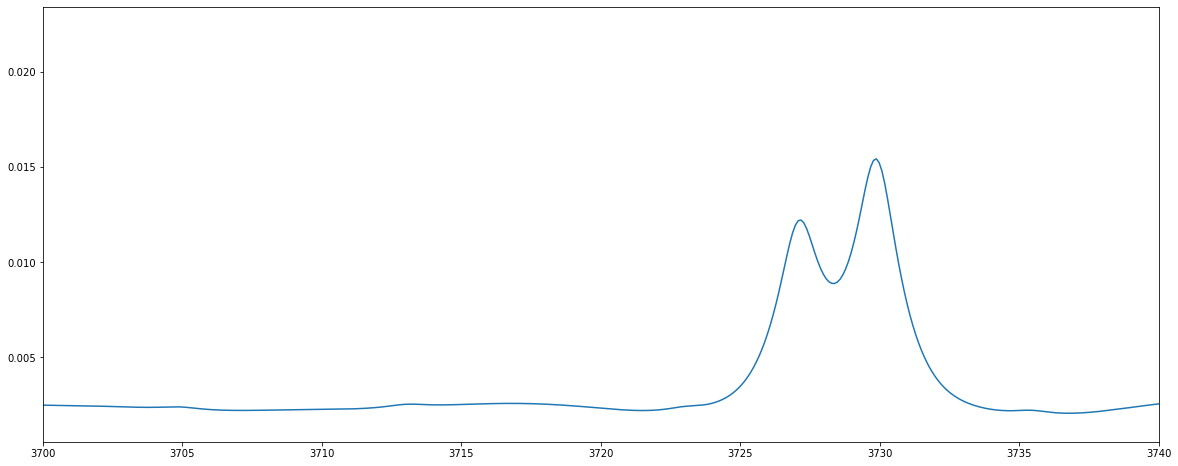

In [30]:
plt.figure(figsize=(20,8))
plt.plot(wave, flux[0,:]) # there are 10 templates. Any spectra can be a linear combination of these 10
plt.xlim(3700, 3740)

In [31]:
flux.shape

(10, 97720)